# Medical Appointment No Shows

<b> Business Case </b>

The objective of this notebook is to produce a model to predict an appointment's no-show, given a patient. 

<b> Data </b>

The data set shows information of appointments in public hospitals in Vitoria, Espirito Santo, Brazil. 300k medical appointments and its 15 variables (characteristics) of each. The most important one if the patient show-up or no-show the appointment. 


In [1]:
import os
import numpy as np 
import pandas as pd 
from scipy import stats as ss
import statsmodels.api as sm
import sklearn.metrics as ssm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

import numpy as np 
import pandas as pd 
from scipy import stats as ss
import statsmodels.api as sm
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import shap 

C:\Users\A666524\AppData\Local\Continuum\anaconda3\envs\health\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df = pd.read_csv("./data/noshows.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<b> Exploratory Data Analysis and Feature Engineering </b>

In [4]:
#change patient Id to integer
df[~ df.PatientId.apply(lambda x: x.is_integer())]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
3950,93779.52927,5712759,F,2016-05-18T09:12:29Z,2016-05-18T00:00:00Z,33,CENTRO,0,0,0,0,0,0,No
73228,537615.28476,5637728,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,0,0,1,No
73303,141724.16655,5637648,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,0,0,0,No
100517,39217.84439,5751990,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,0,0,0,No
105430,43741.75652,5760144,M,2016-06-01T14:22:58Z,2016-06-01T00:00:00Z,39,MARIA ORTIZ,0,0,1,0,0,0,No


In [5]:
df['PatientId'] = df['PatientId'].astype('int64')


Our index should be AppointmentID, has we are trying to determine no-show probability per appointment, given a certain patient. This will allow us to do feature engineering, using patient history. 

In [6]:
df.set_index('AppointmentID', inplace = True)

In [7]:
df.shape

(110527, 13)

As mentioned before, to build new features related to the apointment, is necessary to check how many patients there are, and how much appointments per patient there is.

In [8]:
print('Total appointments: ' + format(df.shape[0], ",d"))
print('Distinct patients: ' + format(df['PatientId'].unique().shape[0], ",d"))
print('Number of appointments per patients: ' + format(df.shape[0]/df['PatientId'].unique().shape[0]))

Total appointments: 110,527
Distinct patients: 62,299
Number of appointments per patients: 1.7741376266071687


In [9]:
print('Patients with more than one appointment: ' + format((df['PatientId'].value_counts() > 1).sum(), ",d"))

Patients with more than one appointment: 24,379


In [10]:
# create variable with previous appointments
df['PreviousApp'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()

In [11]:
# check recurrence
a = df.groupby(pd.cut(df.PreviousApp, bins = [-1, 0,1,2,3,4,5, 85], include_lowest = True))[['PreviousApp']].count()
b = pd.DataFrame(a)
b.set_index(pd.Series(['0', '1', '2', '3', '4', '5', '> 5']))

,PreviousApp
0,62299
1,24379
2,10484
3,4984
4,2617
5,1498
> 5,4264


 We need to build the rate of previous no-show per patients, for those with more than 1 PreviousApp.

In [12]:
df['NoShow'] = (df['No-show'] == 'Yes')*1

In [13]:
df['PreviousNoShow'] = (df[df['PreviousApp'] > 0].sort_values(['PatientId', 'ScheduledDay']).groupby(['PatientId'])['NoShow'].cumsum() / df[df['PreviousApp'] > 0]['PreviousApp'])

In [14]:
df['PreviousNoShow'].describe()

count    48228.000000
mean         0.199614
std          0.342456
min          0.000000
25%          0.000000
50%          0.000000
75%          0.333333
max          1.000000
Name: PreviousNoShow, dtype: float64

More than half of people with previous appointment have gone to all the appointments scheduled. Later on we'll study if this variable is important to predict No-Show, even though it has lots of missings. 



In [15]:
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

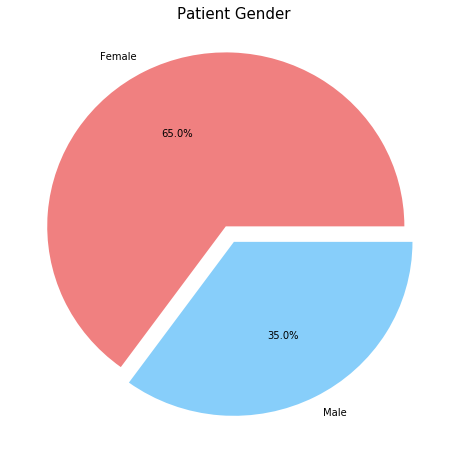

In [16]:
colors = ['lightcoral', 'lightskyblue']

plt.pie([71840, 38687], explode = (0.1, 0), labels = ['Female', 'Male'], colors = colors, autopct='%1.1f%%') 

plt.title('Patient Gender', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

We can see that almost two thirds of the appointments are done by women, a number much higher than men. There are no missing nor atypical values.

In [17]:
# change date format
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['ScheduledDay2'] = df.apply(lambda x: x.ScheduledDay.strftime("%x"), axis = 1)
scheduled_days = df.groupby(['ScheduledDay2'])[['ScheduledDay']].count()

In [18]:
scheduled_days.reset_index(inplace = True)
scheduled_days.columns = ['Date', 'Count']

In [19]:
scheduled_days['Date'] = pd.to_datetime(scheduled_days['Date'])

In [20]:
print('first scheduled: ' + str(scheduled_days.Date.min()))
print('most recent scheduled: ' + str(scheduled_days.Date.max()))

first scheduled: 2015-11-10 00:00:00
most recent scheduled: 2016-06-08 00:00:00


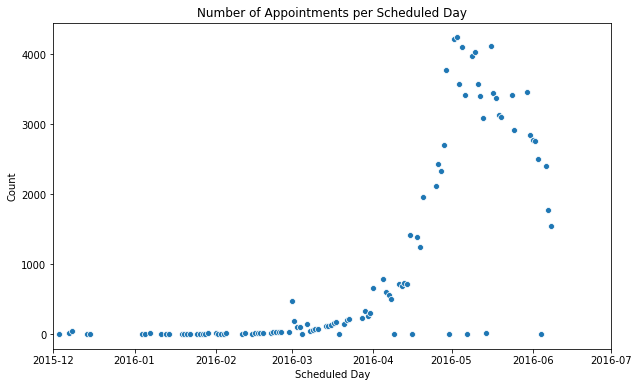

In [21]:
sns.scatterplot(x = 'Date', y = 'Count', data = scheduled_days)
plt.title('Number of Appointments per Scheduled Day')
plt.xlabel('Scheduled Day')
plt.xlim('2015-12', '2016-07')
plt.gcf().set_size_inches(10, 6)
plt.show()

There appears to be some days with significantly less appointments (maybe during weekends). Also, we can see that most of the appointments where scheduled between April and June 2016. As the appointments are not equally distributed in time (more appointments in some months), we decide to take as variable the appointment's scheduled day of week (Monday, Tuesday, and so on). 

In [22]:
df['WeekdayScheduled'] = df.apply(lambda x: x.ScheduledDay.isoweekday(), axis = 1)
df['WeekdayScheduled'].value_counts()

2    26168
3    24262
1    23085
5    18915
4    18073
6       24
Name: WeekdayScheduled, dtype: int64

There appears to be 24 atypical observations: appointments scheduled on Saturdays. We will delete this values. 

On the other hand, most appointments are scheduled on Tuesdays and Wednesdays. No appointments were scheduled on Sundays. 

In [23]:
df = df[df['WeekdayScheduled'] < 6]

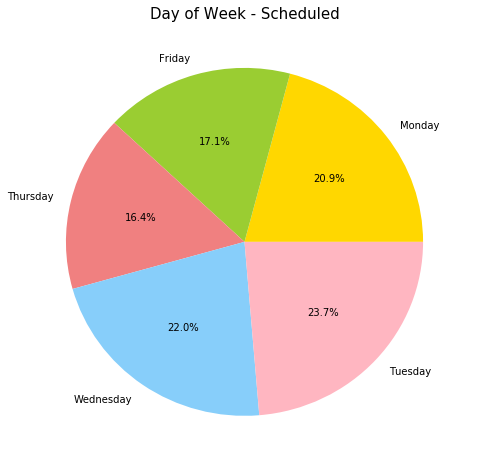

In [24]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink']

plt.pie([df['WeekdayScheduled'].value_counts()[1], df['WeekdayScheduled'].value_counts()[5], 
         df['WeekdayScheduled'].value_counts()[4], df['WeekdayScheduled'].value_counts()[3], df['WeekdayScheduled'].value_counts()[2]], 
        labels = ['Monday','Friday','Thursday','Wednesday' ,'Tuesday'], 
        colors = colors, autopct='%1.1f%%') 

plt.title('Day of Week - Scheduled', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

Same as before, we change to datetime

In [25]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
appoint_days = df.groupby(['AppointmentDay'])[['No-show']].count()

The hour associated for each appointment is 00:00:00, which means that the hour of appointment was not recorded. 

In [26]:
appoint_days.reset_index(inplace = True)
appoint_days.columns = ['Date', 'Count']
appoint_days['Date'] = pd.to_datetime(appoint_days['Date'])

In [27]:
print('first appointment: ' + str(appoint_days.Date.min()))
print('most recent appointment: ' + str(appoint_days.Date.max()))

first appointment: 2016-04-29 00:00:00
most recent appointment: 2016-06-08 00:00:00


We can see that, even though appointments were scheduled over seven months, the appointments themselves occured between April 29th and June 8th 2016 (41 days).

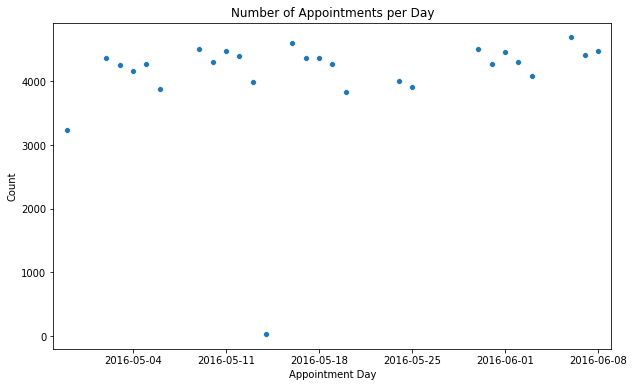

In [28]:
sns.scatterplot(x = 'Date', y = 'Count', data = appoint_days)
plt.title('Number of Appointments per Day')
plt.xlabel('Appointment Day')
plt.xlim('2016-04-28', '2016-06-09')
plt.gcf().set_size_inches(10, 6)
plt.show()

There's one day ('2016-05-14'') with a much lower number of appointments. Checking the date, May 14th was Saturday which can explain the low number. The rest of days with appointments are during workweek (M-F). 

Looking at the plot, there seems to be a relation between the number of appointments and the day of the week, so we build the variable WeekdayAppointment (Monday is 1 and Sunday 7): 

In [29]:
df['WeekdayAppointment'] = df.apply(lambda x: x.AppointmentDay.isoweekday(), axis = 1)
df['WeekdayAppointment'].value_counts()

3    25866
2    25637
1    22709
5    19015
4    17245
6       31
Name: WeekdayAppointment, dtype: int64

Most of appointments happened between Monday and Wednesday. Again, we see the atypical values which we will delete from the base to avoid overfitting to particular cases. 

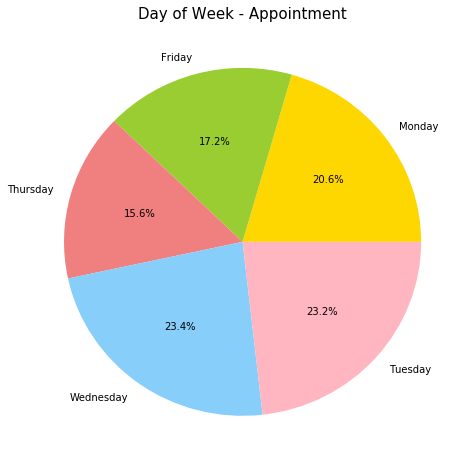

In [30]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink']
df2 = df[df['WeekdayAppointment'] < 6]

plt.pie([df2['WeekdayAppointment'].value_counts()[1], df2['WeekdayAppointment'].value_counts()[5], 
         df2['WeekdayAppointment'].value_counts()[4], df2['WeekdayAppointment'].value_counts()[3], df2['WeekdayAppointment'].value_counts()[2]], 
        labels = ['Monday','Friday','Thursday','Wednesday' ,'Tuesday'], 
        colors = colors, autopct='%1.1f%%') 

plt.title('Day of Week - Appointment', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

In [31]:
df2['Age'].describe()

count    110472.000000
mean         37.083768
std          23.110239
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

We have to filter the data, in order to delete negative ages. As for the maximum, it is rare but possible for a patient to be 115 years old so we won't delete these observations. 

In [32]:
print('Number of obs with negative age: ' + format(df2[df2['Age'] < 0].shape[0]))

Number of obs with negative age: 1


In [33]:
df2 = df2[df2['Age'] >=0]
ages = df2.groupby(['Age'])[['PatientId']].count()
ages.reset_index(inplace = True)
ages.columns = ['Age', 'Count']

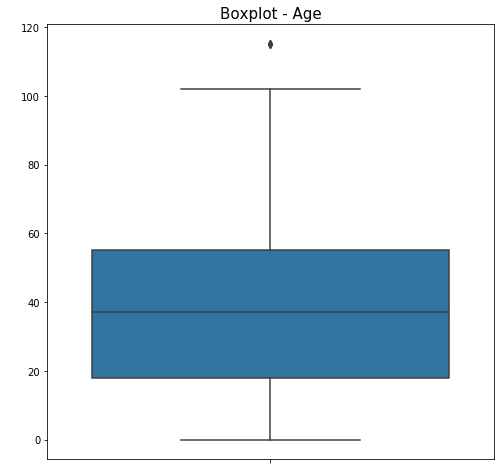

In [34]:
ax = sns.boxplot(x=df2['Age'], orient = 'v')

#plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Boxplot - Age', fontsize = 15)
plt.gcf().set_size_inches(8, 8)
plt.show()

According to the boxplot, there are a few outliers with ages above 110. Checking the data, the observations aged 115 years old are from two persons which is possible, so the data will be taken in account.  

In [35]:
df2[df2['Age'] > 110]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PreviousApp,NoShow,PreviousNoShow,ScheduledDay2,WeekdayScheduled,WeekdayAppointment
AppointmentID,,,,,,,,,,,,,,,,,,,
5700278,31963211613981,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes,1,1,1.000000,05/16/16,1,4
5700279,31963211613981,F,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes,2,1,1.000000,05/16/16,1,4
5562812,31963211613981,F,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,Yes,0,1,NaN,04/08/16,5,1
5744037,31963211613981,F,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,No,3,0,0.666667,05/30/16,1,1
5717451,748234579244724,F,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,No,0,0,NaN,05/19/16,4,5


From the metadata included in the dataset, we can see that the neighbourhood refers to where the appointment takes place. 

In [36]:
print('Number of different Neighbourhoods: ' + format(df2['Neighbourhood'].value_counts().size))

Number of different Neighbourhoods: 81


Given that the objective is to train an XGBoost model  and due to the lack of information regarding metadata, the neighbourhood won't be used in the model. 

<b> Scholarship </b>

According to the information given, this variable indicates if the patient is part of a Social Welfare program given by the Brazilian government which gives financial aid to poor families. If families have children, the money is conditionate to children attending school and being vaccinated. 

This variable will be used as an indicator if the patient is part of a less fortunate family. 

In [37]:
df2['Scholarship'].value_counts() 

0    99614
1    10857
Name: Scholarship, dtype: int64

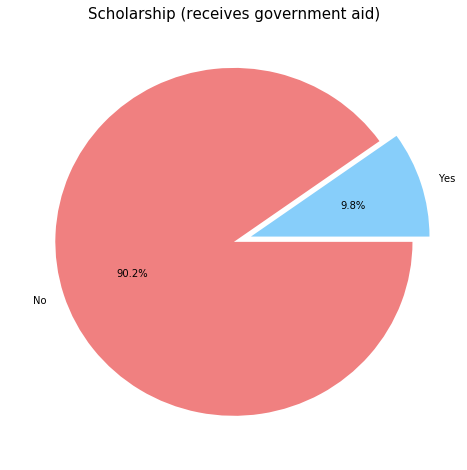

In [38]:
colors = ['lightskyblue','lightcoral']

plt.pie([df2['Scholarship'].value_counts()[1] ,df2['Scholarship'].value_counts()[0] ], explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Scholarship (receives government aid)', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

More than 90% appointments are associated with patients who don't receive government aid. 

h) Hipertension

The variable is one if the patient has hipertension diagnosed. 

In [39]:
df2['Hipertension'].value_counts()

0    88690
1    21781
Name: Hipertension, dtype: int64

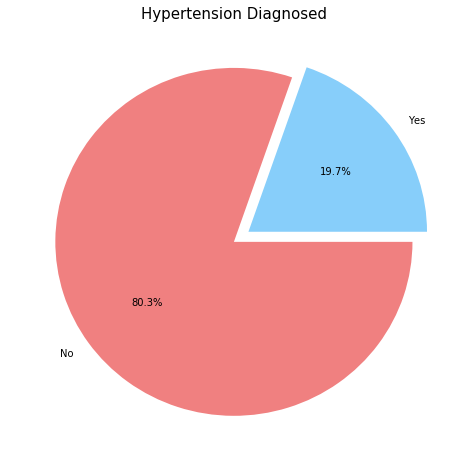

In [40]:
plt.pie([df2['Hipertension'].value_counts()[1] ,df2['Hipertension'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Hypertension Diagnosed', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

More than 80% of patients do not have hipertension. 

Indicates whether the patient has diabetes. 

In [41]:
df2['Diabetes'].value_counts()

0    102537
1      7934
Name: Diabetes, dtype: int64

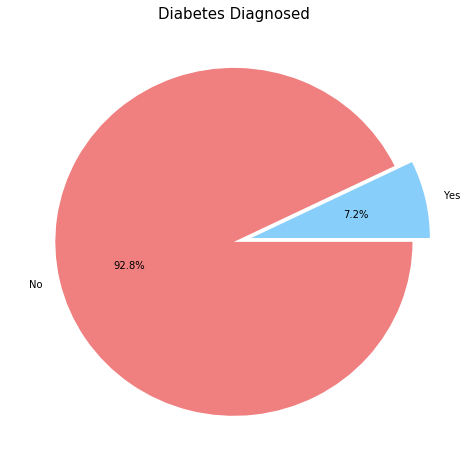

In [42]:
plt.pie([df2['Diabetes'].value_counts()[1] ,df2['Diabetes'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Diabetes Diagnosed', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

More than 90% of patients do not have diabetes. 

<b> Alcoholism </b>

The variable is equal to one if the patient has alcoholism. 

In [43]:
df2['Alcoholism'].value_counts()

0    107113
1      3358
Name: Alcoholism, dtype: int64

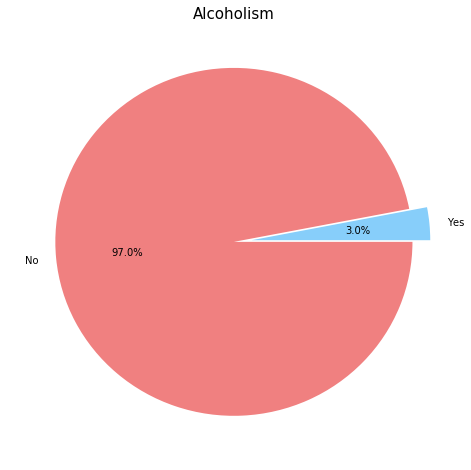

In [44]:
plt.pie([df2['Alcoholism'].value_counts()[1] ,df2['Alcoholism'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Alcoholism', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

Only 3% of the appointments are associated with alcoholic patients. 

<b> Handcap </b>

This variable indicates the number of handicaps a patient is suffering from. 

In [45]:
df2['Handcap'].value_counts()

0    108231
1      2041
2       183
3        13
4         3
Name: Handcap, dtype: int64

As most of patients do not have a handicap associated, we re-group the variable into a boolean: HasHandicap, which is cero if the patient has no handicaps and one in any other case. 

In [46]:
df2['HasHandicap'] = (df['Handcap'] > 0)*1

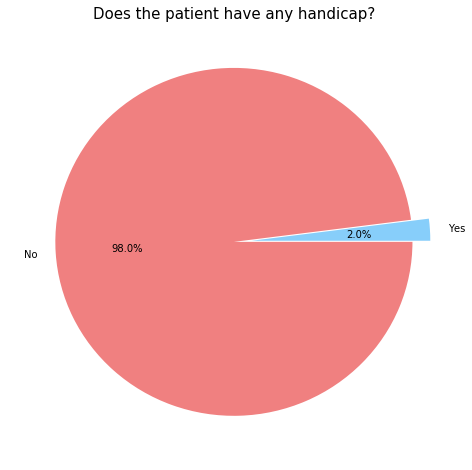

In [47]:
plt.pie([df2['HasHandicap'].value_counts()[1] ,df2['HasHandicap'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Does the patient have any handicap?', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

Only 2% of patients suffer from some kind of handicap. 

Indicates whether a SMS was sent to the patient to remind him/her of the appointment. 

In [48]:
df2['SMS_received'].value_counts()

0    75006
1    35465
Name: SMS_received, dtype: int64

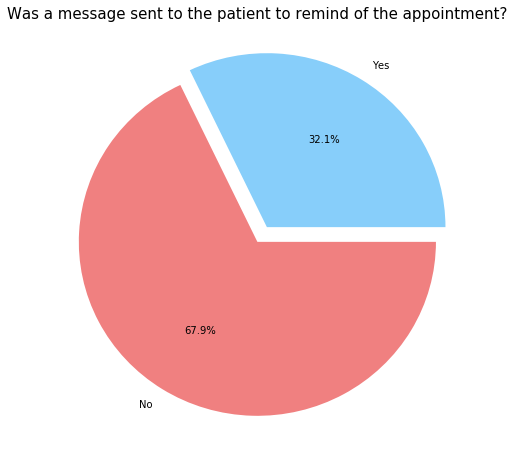

In [49]:
plt.pie([df2['SMS_received'].value_counts()[1] ,df2['SMS_received'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Was a message sent to the patient to remind of the appointment?', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

Reminder SMS were sent for 32.1% of the appoitments. 

<b> Previous Disease </b>

This variable will summarize all patients with some disease diagnosed: hipertension, diabetes or alcoholism.

In [50]:
df2['PreviousDisease'] = df2.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)

In [51]:
df2['PreviousDisease'].value_counts()

0    87235
1    23236
Name: PreviousDisease, dtype: int64

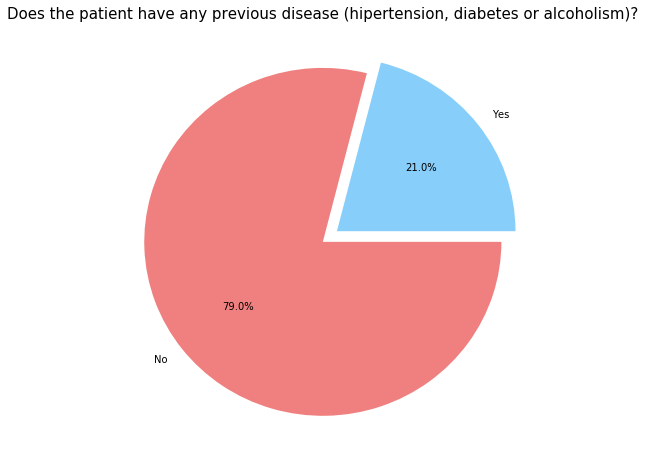

In [52]:
plt.pie([df2['PreviousDisease'].value_counts()[1] ,df2['PreviousDisease'].value_counts()[0] ], 
        explode = (0.1, 0), labels = ['Yes', 'No'], colors = colors, autopct='%1.1f%%') 

plt.title('Does the patient have any previous disease (hipertension, diabetes or alcoholism)?', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

The reason to create this variable is to check if patients with diseases (no matter which) have similar behavior regarding medical appointment no-show. 

<b> Days before appointment </b>

Indicates the number of days between scheduled day and appointment day. 

In [53]:
def get_day(x):
    return x.date()

df2['DaysBeforeApp'] = ((df2.AppointmentDay.apply(get_day) - df2.ScheduledDay.apply(get_day)).astype('timedelta64[D]')).astype(int)

In [54]:
df2['DaysBeforeApp'].value_counts()

 0      38554
 2       6714
 4       5285
 1       5212
 7       4906
 6       4037
 5       3274
 14      2913
 3       2729
 8       2331
 21      1861
 28      1706
 13      1681
 9       1601
 15      1503
 10      1390
 20      1185
 22      1173
 16      1151
 12      1110
 17      1107
 29      1089
 19      1044
 18      1021
 27      1013
 11       985
 35       963
 23       822
 34       808
 26       730
        ...  
 98         5
 112        5
 103        5
 109        5
 108        5
 102        4
-1          4
 105        4
 96         4
 119        4
 122        3
 92         3
 115        2
 93         2
 110        2
 107        2
 97         2
 94         2
 123        1
 101        1
 126        1
 125        1
 139        1
 151        1
 132        1
 117        1
 146        1
 82         1
-6          1
 127        1
Name: DaysBeforeApp, dtype: int64

Most of appointments where scheduled less than one day in advance. There are negative values which must be studied further:

In [55]:
df2[df2['DaysBeforeApp'] < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,No-show,PreviousApp,NoShow,PreviousNoShow,ScheduledDay2,WeekdayScheduled,WeekdayAppointment,HasHandicap,PreviousDisease,DaysBeforeApp
AppointmentID,,,,,,,,,,,,,,,,,,,,,
5679978,7839272661752,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,...,Yes,0,1,NaN,05/10/16,2,1,1,0,-1
5715660,7896293967868,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,...,Yes,4,1,0.25,05/18/16,3,2,1,0,-1
5664962,24252258389979,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,...,Yes,1,1,1.00,05/05/16,4,3,0,0,-1
5686628,998231581612122,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,...,Yes,1,1,1.00,05/11/16,3,4,0,0,-6
5655637,3787481966821,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,...,Yes,0,1,NaN,05/04/16,3,2,0,0,-1


From the above, we see that all five scheduled after the appointment are No-shows. This might mean that the hospital made a mistake and scheduled appointments that where not real. For this reason, this observations will be deleted (as there are only 5 of them, it won't have a major impact in the model). 

In [56]:
df3 = df2[df2['DaysBeforeApp'] >= 0]

In [57]:
days_before = df3.groupby(['DaysBeforeApp'])[['No-show']].count()
days_before.reset_index(inplace = True)
days_before.columns = ['Days Ahead', 'Count']

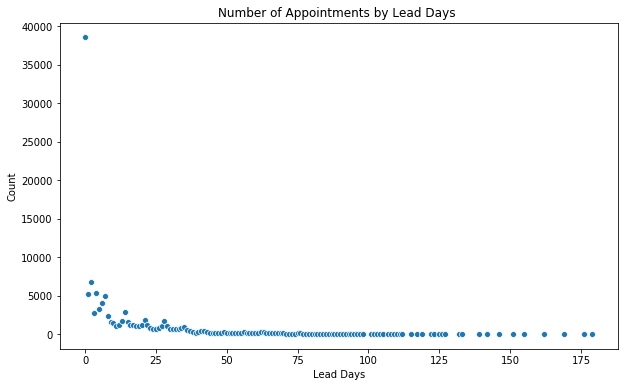

In [58]:
sns.scatterplot(x = 'Days Ahead', y = 'Count', data = days_before)
plt.title('Number of Appointments by Lead Days ')
plt.xlabel('Lead Days')
#plt.xlim('2016-04-28', '2016-06-09')
plt.gcf().set_size_inches(10, 6)
plt.show()

Most appointments are scheduled less than a day in advance. We will categorize this variable to group similar situations (this will implicate that, for the model, one hot encoding will be necessary in order to use the categorized variable). 

In [59]:
def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'
    
df3['DaysBeforeCat'] = df3.DaysBeforeApp.apply(DaysBeforeCat)

C:\Users\A666524\AppData\Local\Continuum\anaconda3\envs\health\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [60]:
df3['DaysBeforeCat'].value_counts()

0 days       38554
8-31 days    30051
3-7 days     20231
1-2 days     11926
> 31 days     9704
Name: DaysBeforeCat, dtype: int64

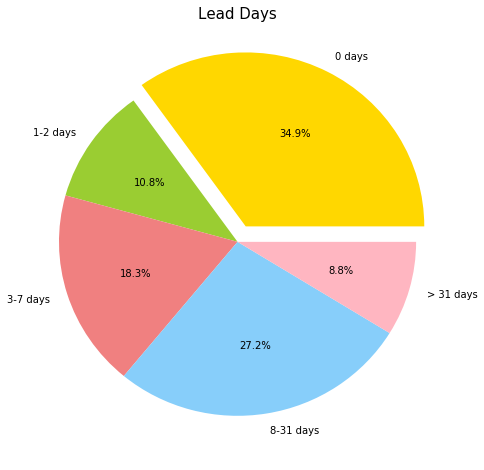

In [61]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightpink']

plt.pie([df3['DaysBeforeCat'].value_counts()[0], df3['DaysBeforeCat'].value_counts()[3], 
         df3['DaysBeforeCat'].value_counts()[2], df3['DaysBeforeCat'].value_counts()[1], df3['DaysBeforeCat'].value_counts()[4]], 
        labels = ['0 days','1-2 days' ,'3-7 days','8-31 days','> 31 days'], 
        explode = (0.1, 0, 0, 0, 0),
        colors = colors, autopct='%1.1f%%') 

plt.title('Lead Days', fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.show()

For XGBoost, it's very important to know the proportion of yes/no in the sample, as the parameter scale_pos_weight allows to work with unbalanced data without sampling or discarding observations. 

In [62]:
df3['No-show'].value_counts()[1]

22304

In [63]:
ns = df3['No-show'].value_counts()[1]
show = df3['No-show'].value_counts()[0]
rate = (show + 0.0) / ns
print('For every no-show, there are {:1.2f} shows'.format(rate))

For every no-show, there are 3.95 shows


We have approximately 4 shows for every no-show. 

<b> Data checks </b>

We will check a couple of "common sense" rules regarding the data we have:
* Medical conditions (such as hypertension, diabetes and alcoholism) should have a unique value per patient
* Schedule day should take place before appointment day
* For every patient, the age should not differ in more than one and, if this is the case, the appointment with higher age should take place after the appointment with lower age
* Gender, handicap and scholarship should have a unique value per patient

In [64]:
def unique_condition(df, var, cols):
    if df.groupby(cols).ngroups == df[var].unique().size:
        return 'Sizes match: unique value per ' + var
    else: 
        return 'Mismatch: more than one value per ' + var

unique_condition(df3, 'PatientId', ['PatientId','Hipertension', 'Diabetes', 
                                    'Alcoholism', 'Gender', 'Handcap', 'Scholarship'])

'Sizes match: unique value per PatientId'

From the above, we have checked that there's one value of Hipertension, Diabetes, Alcoholism, Gender, Handcap and Scholarship per patient, which were our first and last conditions.

For scheduled day before appointment day, we check that the amount of days before is at least zero (less than zero would mean that the scheduling was done after the appointment - as we do not have the the hour of appointment, we assume all appointments were scheduled at 00:00:00 hrs). 

In [65]:
print('Reservations scheduled after appointment time: ' + str(df3[df3['DaysBeforeApp'] < 0].size))

Reservations scheduled after appointment time: 0


Last, but not least, we'll check that ages do not differ in more than a year per patient: 

In [66]:
inconsist = []
for num in df3['PatientId'].unique():
    ages = df3[df3['PatientId'] == num]['Age'].unique()
    if ages.size == 1:
        break
    if ages.size > 2:
        inconsist.append(num)
        print('Patient ' + str(num)+ 'has age inconsistency')
    else:
        if abs(ages[0]-ages[1]) > 1:
            inconsist.append(num)
            print('Patient ' + str(num)+ 'has age inconsistency')
            
if len(inconsist) == 0:
    print('There is no inconsistency in ages')

There is no inconsistency in ages


We found no inconsistencies in our dataset. 

**Bivariate Analysis**

So far we have managed to collect and analyze the following features:  Gender, ScheduledDay, AppointmentDay, Age, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Handcap, SMS_received, PreviousApp, PreviousNoShow, WeekdayScheduled, WeekdayAppointment, HasHandicap, PreviousDisease, DaysBeforeApp, DaysBeforeCat. 

Based on previous analysis, we've discarded ScheduledDay, AppointmentDay (we are going to use the weekday of both), Neighbourhood (too many categories), Handcap and DaysBeforeApp (as we categorized them).  Now we will study each feature and its relation with No-Show: 

*Gender*


In [67]:
sns.set()

def cat_var(df3, var):
    
    print(df3.groupby([var])['NoShow'].mean())
    
    ns_rate = [df3.groupby([var])['NoShow'].mean()[i] for i in df3[var].unique()]
    s_rate = [1-df3.groupby([var])['NoShow'].mean()[i] for i in df3[var].unique()]
    barWidth = 0.5

    plt.bar(df3[var].unique(), ns_rate, color='lightcoral', edgecolor='white', width=barWidth, label = 'No-Show')
    plt.bar(df3[var].unique(), s_rate, bottom=ns_rate, color='mediumseagreen', edgecolor='white', width=barWidth, label = 'Show')
    plt.axhline(y=df3['NoShow'].mean(), color='black', linewidth= 0.8, linestyle='--', label = 'Overall mean')
    plt.xticks(df3[var].unique())
    plt.xlabel(var)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.title('No-Show Rate by '+ var, fontsize=15)
    plt.gcf().set_size_inches(6, 6)
    plt.show() 
    
    counts = np.array(df3.groupby([var])['NoShow'].sum())
    nobs = np.array(df3.groupby([var])['NoShow'].count())

    table = df3.groupby(['NoShow', var]).size().unstack(var)
    pvalue = ss.chi2_contingency(table.fillna(0))[1]
    
    print('Means test p-value: {:1.3f}'.format(pvalue))
    if pvalue < 0.05:
        print('Reject null hypothesis: no-show rate is different for at least one group')
    else:
        print('Cannot reject no-show rates are same for all groups')

Gender
F    0.203131
M    0.199638
Name: NoShow, dtype: float64


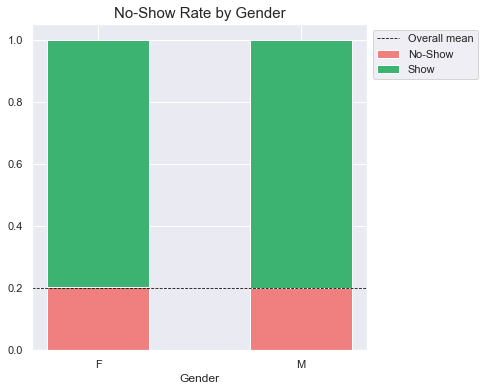

Means test p-value: 0.170
Cannot reject no-show rates are same for all groups


In [68]:
cat_var(df3, 'Gender')

Based on the analysis, we cannot say that no-show rates are different for men and women, which could indicate that the variable Gender is not a relevant one when predicting no-show. We shall include the variable as well because, interacting with others, Gender could gain relevance and became a good discriminator. 

*Age*

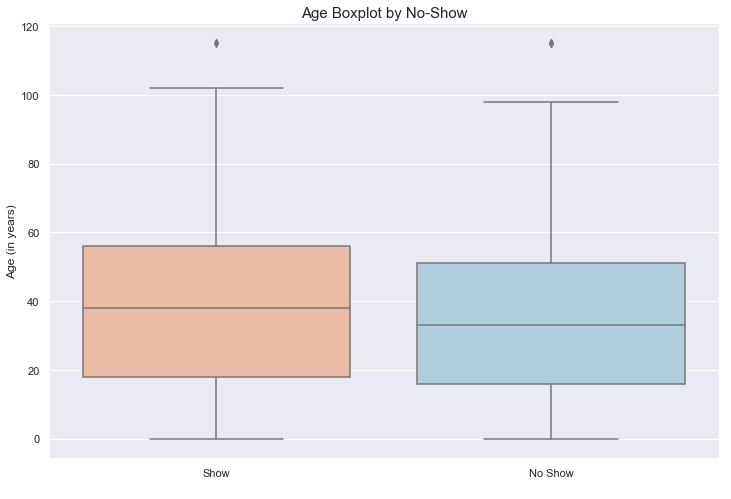

In [69]:
ax = sns.boxplot(x="NoShow", y="Age",data= df3, palette = 'RdBu')
ax.set_xticklabels(['Show', 'No Show'])
plt.xlabel(' ')
plt.ylabel('Age (in years)')
plt.title('Age Boxplot by No-Show', fontsize = 15)
plt.gcf().set_size_inches(12, 8)
plt.show()

From the boxplot, we can see that people who don't show up to appointments tend to be younger than those who attend (based on quartiles). 

In [70]:
print('Correlation with No-Show: %.3f' % ss.pointbiserialr(df3['NoShow'], df3['Age'])[0])


Correlation with No-Show: -0.060


Correlation with no-show is very close to zero,which could indicate that the variable is not of much interest when predicting no-show. 

*Scholarship*

Scholarship
0    0.198034
1    0.237450
Name: NoShow, dtype: float64


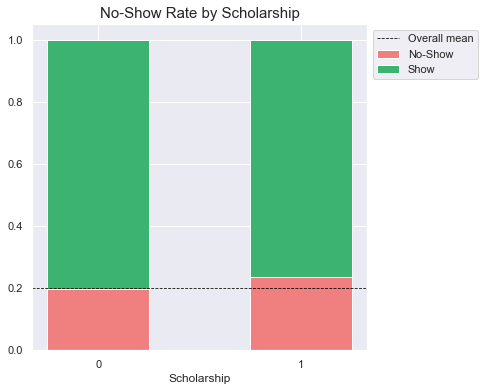

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [71]:
cat_var(df3, 'Scholarship')

From the above, we can assure that patients who are part of the Social Welfare program have significantly higher no-show rates than people without this government support. This could mean that the variable is very important for predicting no-show.

*Hypertension*

Hipertension
0    0.209021
1    0.172949
Name: NoShow, dtype: float64


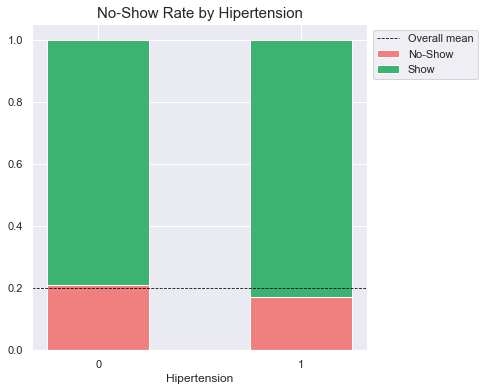

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [72]:
cat_var(df3, 'Hipertension')

As before, we can reject that people with hypertension present same no-show rates as patients without hypertension diagnosed. This difference is significant, which indicates that the variable is of interest for predicting no-show. People with hypertension tend to have lower no-show rates (maybe because they are in some kind of treatment...)

*Diabetes*

Diabetes
0    0.203614
1    0.179859
Name: NoShow, dtype: float64


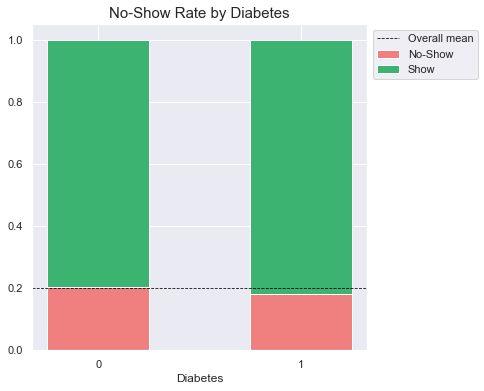

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [73]:
cat_var(df3, 'Diabetes')

From the test, we can reject the hypothesis that no-show rates are the same for patients with diabetes and those without. This implies that the variable Diabetes is of interest for our model. 

*Alcoholism*

Alcoholism
0    0.201918
1    0.201608
Name: NoShow, dtype: float64


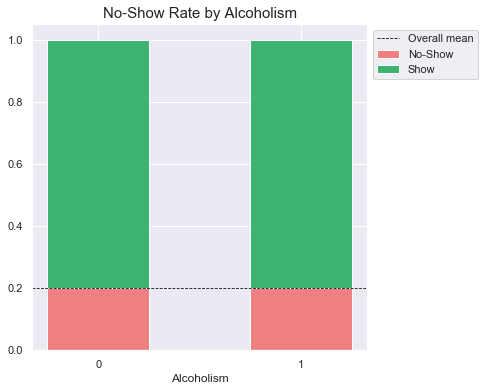

Means test p-value: 0.982
Cannot reject no-show rates are same for all groups


In [74]:
cat_var(df3, 'Alcoholism')

As mentioned above, we cannot reject that the mean rates are equal, despite the group (Alcoholic vs Non-alcoholic). Therefore, the variable Alcoholism may be not important to discriminate between no shows/shows. 

*SMS_received*

SMS_received
0    0.166971
1    0.275793
Name: NoShow, dtype: float64


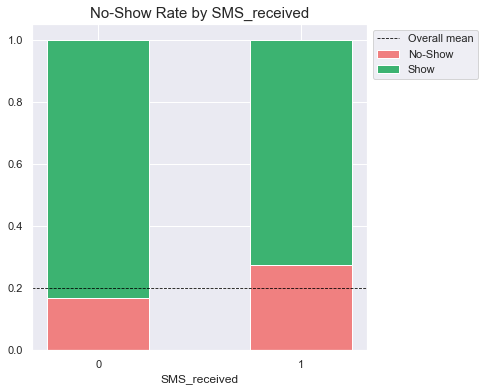

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [75]:
cat_var(df3, 'SMS_received')

If we see the no-show rates per group, there appears to be something strange in the data, as one could suppose that if a patient receives a SMS to remind him/her the appointment, this patient is less likely to miss the appointment. 

We will analyze how SMS are sent in relation with anticipation of scheduling. 

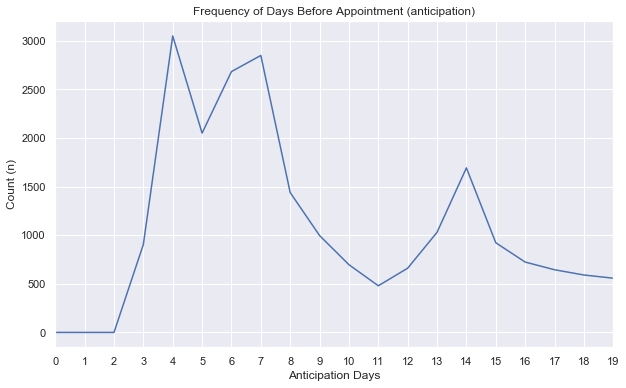

In [77]:
aux = df3.groupby(['DaysBeforeApp'])[['SMS_received']].agg(['count','sum'])
aux.columns = ['count', 'SMS_received']
aux[:20]['SMS_received'].plot()
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Anticipation Days')
plt.ylabel('Count (n)')
plt.title('Frequency of Days Before Appointment (anticipation)')
plt.xticks(range(0, 20))
plt.show()

From the plot above, we can see that there are no SMS sent for appointments scheduled less than two days before. Even so, the number of messages sent grows at 4 days before. So we will filter the data by appointments scheduled with more than 4 days of anticipation and re-analyze the variable. 

SMS_received
0    0.333612
1    0.277431
Name: NoShow, dtype: float64


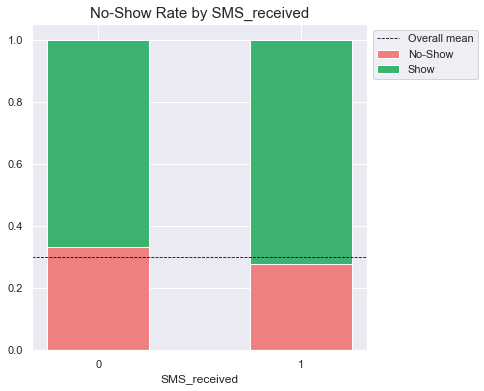

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [78]:
fourdaysormore = df3[df3['DaysBeforeApp'] > 3]
cat_var(fourdaysormore, 'SMS_received')

Now the analysis makes more sense: patients who didn't receive a reminder SMS have higher no-show rates than those who did receive a SMS. This differences are statistically significant, so the variable together with days before appointment is of interest for our model. 

*PreviousApp*

We will study no-show rates grouped by number of previous appointments, for categories with at least 30 appointments: 

In [79]:
prevapp = df3.groupby(['PreviousApp'])[['NoShow']].agg(['count', 'mean'])
prevapp.columns = ['count', 'NoShow_rate']

In [80]:
prevapp.reset_index(inplace = True)

In [81]:
import warnings
warnings.filterwarnings("ignore")
prevapp = prevapp[(prevapp['count'] > 30) & (prevapp['PreviousApp'] > 0)]

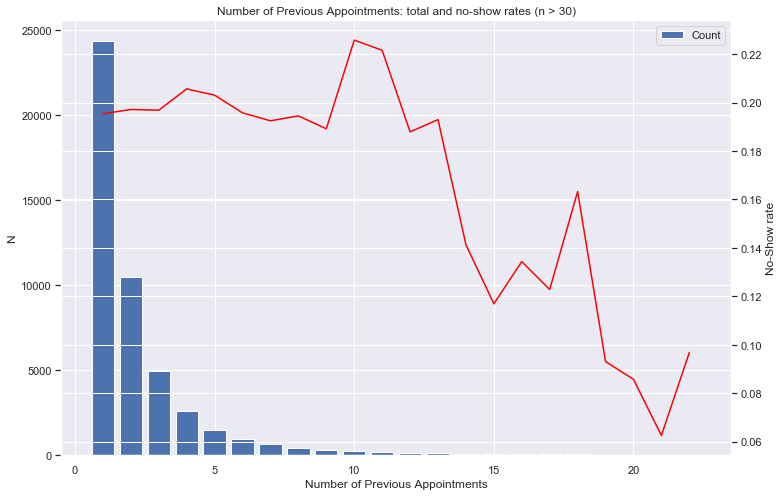

In [82]:
fig = plt.figure()

count = fig.add_subplot(111)
rate = count.twinx()

count.set_ylabel('N')
rate.set_ylabel('No-Show rate')

line1 = count.bar(prevapp['PreviousApp'], prevapp['count'])
line2 = rate.plot(prevapp['PreviousApp'], prevapp['NoShow_rate'], color = 'red', label = 'No-show Rate')
count.legend([line1, line2], ['Count', 'No-show Rate'])
plt.gcf().set_size_inches(12, 8)
count.set_xlabel('Number of Previous Appointments')
plt.title('Number of Previous Appointments: total and no-show rates (n > 30)')
plt.show()

We decided to eliminate from the plot appointments without previous appointments, as they are a much higher number than other categories and makes the plot more confusing. From the above, and considering we are only observing groups with more than 30 observations, we can say that no show rate are higher for patients with 10-12 previous appointments and then the no show rates descend drastically (patients with lots of previous appointments are likely to be in a treatment as the data is condensed in 41 days). 

In [83]:
print('Correlation with No-Show (all appointments): %.3f' % ss.pointbiserialr(df3['NoShow'], df3['PreviousApp'])[0])
print('Correlation with No-Show (1 or more previous app): %.3f' % ss.pointbiserialr(df3[df3['PreviousApp'] > 0]['NoShow'], df3[df3['PreviousApp'] > 0]['PreviousApp'])[0])

Correlation with No-Show (all appointments): -0.035
Correlation with No-Show (1 or more previous app): -0.048


The point biserial correlation is -0.035 and if we calculate the correlation without first-time-appointments, the value is closer to -1, indicating a stronger negative correlation. 

*PreviousNoShow*

We will study no-show rates, grouping appointments by PreviousNoShow deciles. 

In [84]:
prop_ns = df3.groupby(pd.cut(df3['PreviousNoShow'], np.arange(0, 1.05, 0.05), include_lowest = True))[['NoShow']].mean()
prop_ns = prop_ns.reset_index()
prop_ns['middle'] = np.arange(0.025, 1.025, 0.05)
prop_ns.iloc[0,2] = 0
prop_ns.iloc[19,2] = 1

In [85]:
no_na = df3.dropna(subset = ['PreviousNoShow'])

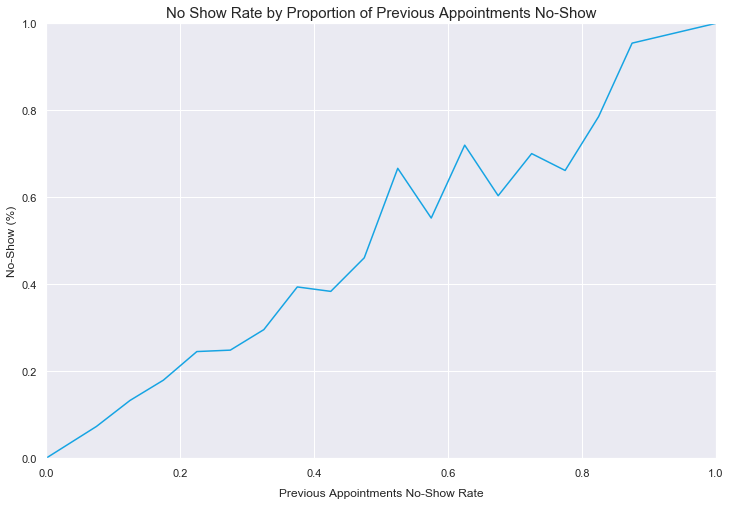

Correlation with No-Show: 0.854


In [86]:
prop_ns = prop_ns.drop([18], axis = 0)
plt.plot(prop_ns['middle'], prop_ns['NoShow'], color = '#16a4e3')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Previous Appointments No-Show Rate', labelpad=10)
plt.ylabel('No-Show (%)')
plt.grid(True)
plt.gcf().set_size_inches(12, 8)
plt.title('No Show Rate by Proportion of Previous Appointments No-Show', fontsize = 15)

plt.show()

print('Correlation with No-Show: %.3f' % ss.pointbiserialr(no_na['NoShow'], no_na['PreviousNoShow'])[0])


(The interval [0.9, 0.95] was deleted as there were no appointments with previous no show rate between this values). As expected, previous patient behavior and no-show rate have an almost perfect linear relation. This supports the hypothesis that people tend to mantain certain behaviors in time. Moreover, the correlation between the variables is very close to 1, indicating a strong and positive correlation between previous no show and appointment noshow. For this, pevious behavior is a variable of interest for our model. 

*WeekdayScheduled*


WeekdayScheduled
1    0.197608
2    0.202133
3    0.201006
4    0.204562
5    0.205467
Name: NoShow, dtype: float64


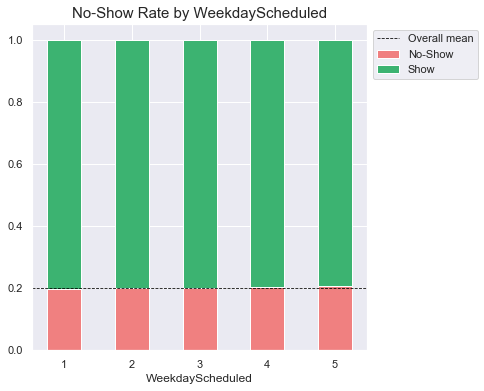

Means test p-value: 0.282
Cannot reject no-show rates are same for all groups


In [87]:
cat_var(df3, 'WeekdayScheduled')

From the above, the variable apparently isn't of interest as no-show rates are not statistically different between groups (per Scheduled Day). 

*WeekdayAppointment*

WeekdayAppointment
1    0.206456
2    0.200897
3    0.196868
4    0.193517
5    0.212306
Name: NoShow, dtype: float64


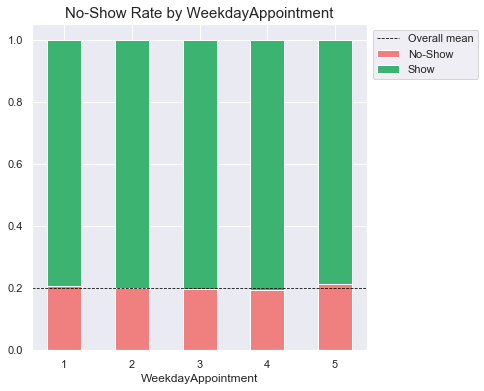

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [88]:
cat_var(df3, 'WeekdayAppointment')

Unlike weekday scheduled, for weekday appointment the differences between group are significant. Appointments on Friday have higher no-show rates than rest of the week, while the lowest no-show rate per group is for appointments on Thursday. 

*HasHandicap*

HasHandicap
0    0.202341
1    0.180965
Name: NoShow, dtype: float64


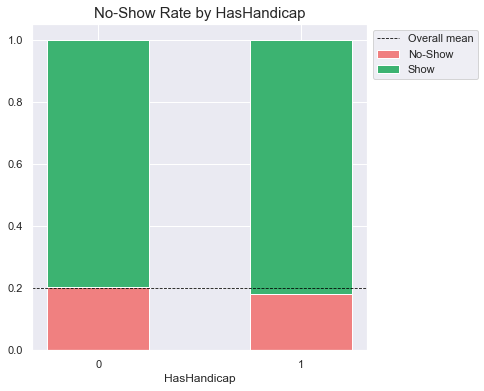

Means test p-value: 0.014
Reject null hypothesis: no-show rate is different for at least one group


In [89]:
cat_var(df3, 'HasHandicap')

Patients who have at leat one handicap have lower no-show rates than those who doesn't have, and this difference is statistically significant. The variable is of interest for our model. 

*PreviousDisease*

PreviousDisease
0    0.209194
1    0.174557
Name: NoShow, dtype: float64


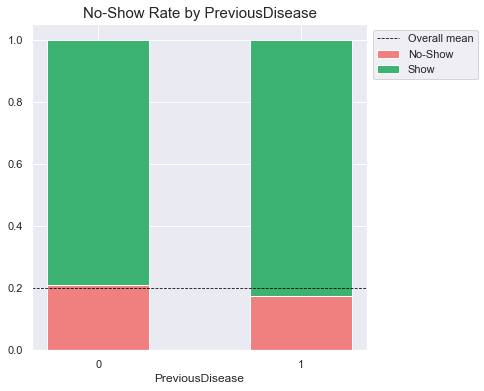

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [90]:
cat_var(df3, 'PreviousDisease')

As expected, no-show rates per group are different. This is consistent with previous analysis, as we saw before that Diabetes and Hypertension are both importante features to predict no-show (variables can separate groups with different no-show mean rates). 

*DaysBeforeCat*

DaysBeforeCat
0 days       0.046480
1-2 days     0.227151
3-7 days     0.249913
8-31 days    0.317527
> 31 days    0.330276
Name: NoShow, dtype: float64


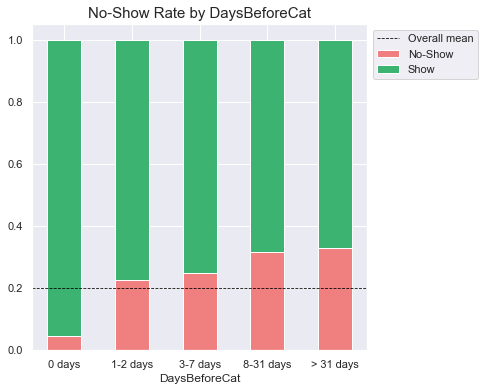

Means test p-value: 0.000
Reject null hypothesis: no-show rate is different for at least one group


In [91]:
cat_var(df3, 'DaysBeforeCat')

From the plot, it is clear that no-show rates are very different in each group: moreover, rates seem to be increasing as the number of days of anticipation is higher. For appointments scheduled in the same day (0 days of anticipation), no-show rates are dramatically lower and very close to zero (only 4.6%). This is clearly evidence enough to consider the variable as highly interesting and important to predict no-show. 

In [95]:
def get_day(x):
    return x.date()

def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

def getting_ready(df):
    
    df['PatientId'].astype('int64')
    #df.set_index('AppointmentID', inplace = True)
    
    # Creating new variables
    df['NoShow'] = (df['No-show'] == 'Yes')*1
    df['PreviousApp'] = df.sort_values(by = ['PatientId','ScheduledDay']).groupby(['PatientId']).cumcount()
    df['PreviousNoShow'] = (df[df['PreviousApp'] > 0].sort_values(['PatientId', 'ScheduledDay']).groupby(['PatientId'])['NoShow'].cumsum() / df[df['PreviousApp'] > 0]['PreviousApp'])
    df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
    df['WeekdayScheduled'] = df.apply(lambda x: x.ScheduledDay.isoweekday(), axis = 1)
    df['HasHandicap'] = (df['Handcap'] > 0)*1
    df['PreviousDisease'] = df.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)
    df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
    df['WeekdayAppointment'] = df.apply(lambda x: x.AppointmentDay.isoweekday(), axis = 1)
    df['DaysBeforeApp'] = ((df.AppointmentDay.apply(get_day) - df.ScheduledDay.apply(get_day)).astype('timedelta64[D]')).astype(int)
    df['DaysBeforeCat'] = df.DaysBeforeApp.apply(DaysBeforeCat)
    
    # Filtering
    
    df2 = df[(df['WeekdayScheduled'] < 6) &
             (df['WeekdayAppointment'] < 6) &
             (df['Age'] >= 0) &
             (df['DaysBeforeApp'] >= 0)]
    
    return df2
    
df_done = getting_ready(df)

In [96]:
df_done.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'PreviousApp',
       'NoShow', 'PreviousNoShow', 'ScheduledDay2', 'WeekdayScheduled',
       'WeekdayAppointment', 'HasHandicap', 'PreviousDisease', 'DaysBeforeApp',
       'DaysBeforeCat'],
      dtype='object')

The features we will use are: Gender, Age, Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, PreviousApp, PreviousNoShow, WeekdayScheduled, WeekdayAppointment, HasHandicap, PreviousDisease, DaysBeforeApp and DaysBeforeCat. 

As XGBoost only receives numerical features, we must transform the categorical variables into dummy variables. We could change each variable to a number but this makes no sense as, for example, Mondays (1 in WeekdayAppointment) is not twice as Tuesdays (2 in WeekdayAppointment). Values must make sense. Given this, the transformations we will apply are: 
* Change Gender to "IsFemale" which takes the value 1 if Gender = F and 0 in other case
* Change WeekdayScheduled to five variables: ScheduledMonday, ScheduledTuesday, ..., ScheduledFriday. Each variable is 1 if the appointment was scheduled in that particular day and 0 in other case. Same transformation will be apply to WeekdayAppointment (variables will be AppointmentMonday and so on)
* Change DaysBeforeCat to five variables: 

In [101]:
# WeekdayScheduled to dummies
df_done = df_done.assign(ScheduledMonday = (df['WeekdayScheduled'] == 1)*1, 
                         ScheduledTuesday = (df['WeekdayScheduled'] == 2)*1, 
                         ScheduledWednesday = (df['WeekdayScheduled'] == 3)*1,
                         ScheduledThursday = (df['WeekdayScheduled'] == 4)*1,
                         ScheduledFriday = (df['WeekdayScheduled'] == 5)*1)

# WeekdayAppointment to dummies
df_done = df_done.assign(AppointmentMonday = (df['WeekdayAppointment'] == 1)*1, 
                         AppointmentTuesday = (df['WeekdayAppointment'] == 2)*1, 
                         AppointmentWednesday = (df['WeekdayAppointment'] == 3)*1,
                         AppointmentThursday = (df['WeekdayAppointment'] == 4)*1,
                         AppointmentFriday = (df['WeekdayAppointment'] == 5)*1)

# Gender to dummy 
df_done['IsFemale'] = (df_done['Gender'] == 'F')*1

# DaysBeforeCat to dummies
def ant_days(df):
    df.loc[:, 'Ant0Days'] = (df['DaysBeforeCat'] == '0 days')*1
    df.loc[:, 'Ant12Days'] = (df['DaysBeforeCat'] == '1-2 days')*1
    df.loc[:, 'Ant37Days'] = (df['DaysBeforeCat'] == '3-7 days')*1
    df.loc[:, 'Ant831Days'] = (df['DaysBeforeCat'] == '8-31 days')*1
    df.loc[:, 'Ant32Days'] = (df['DaysBeforeCat'] == '> 31 days')*1
    
ant_days(df_done)

The features we will use are number type as well as our label (NoShow). For hyperparameter tunning (and model training) we will separate the data between train and test. As data is not so sparse in time, the separation will be done using random sampling, where 70% of the data will be used for training and 30% for testing. 

In [100]:
features = ['Age', 'Scholarship', 'Hipertension', 'Diabetes',
            'Alcoholism', 'SMS_received', 'PreviousApp', 'PreviousNoShow', 
            'HasHandicap', 'PreviousDisease', 'DaysBeforeApp',
            'ScheduledMonday', 'ScheduledTuesday', 'ScheduledWednesday', 
            'ScheduledThursday', 'ScheduledFriday', 'AppointmentMonday', 
            'AppointmentTuesday', 'AppointmentWednesday', 'AppointmentThursday', 
            'AppointmentFriday', 'IsFemale', 'Ant0Days', 'Ant12Days', 
            'Ant37Days', 'Ant831Days', 'Ant32Days']

label = 'NoShow'

To reduce computing times, we will reduce memory usage using a function. Thanks to his work, we are able to perform Bayesian Optimization on hyperparameters in an optimal way.

In [98]:
# https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [102]:
df_done = reduce_mem_usage(df_done)

X_train, X_test, y_train, y_test = train_test_split(df_done[features], df_done[label], test_size=0.3, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

Mem. usage decreased to 11.06 Mb (31.4% reduction)


Predicting a patient not showing up and failing is worse than predicting a patient showing up but then failing. In this case, where success/positive outcome is no-show, this is known as false positive (predicted positive no-show but actually got negative no-show).

If we just wanted to be accurate, then as our data is unbalanced it will be easier to just predict everyone as not no-show and have 79% accuracy (more or less). But then we wouldn't be attacking the problem of no-show. So we must keep in mind that not only accuracy is important, but recall (the hability to capture positive results) is also important. 

As we have more negative results than positive, rather than optimizing for AUROC we will optimize for precision-recall curve (for more info, see [here](http://www.chioka.in/differences-between-roc-auc-and-pr-auc/)). We will define our optimization function, parameters to be evaluated and perform bayesian optimization.

In [104]:
def param_opt_xgb(X, y, init_round=10, opt_round=10, n_folds=3, random_seed=6, output_process=False):
    # Prepare data
    dtest = xgb.DMatrix(X, y)

    def xgb_eval(learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight):
        params = {'objective' : 'binary:logistic', 'nthread' : 4, 'seed' : random_seed, "silent":1}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['n_estimators'] = int(round(n_estimators))
        params['max_depth'] = int(round(max_depth))
        params['min_child_weight'] = int(round(min_child_weight))
        params['gamma'] = gamma
        params['subsample'] = max(min(subsample, 1), 0)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['scale_pos_weight'] = int(round(scale_pos_weight))

        cv_result = xgb.cv(params, dtest, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        
        return max(cv_result['train-auc-mean'])
    
    xgbBO = BayesianOptimization(xgb_eval, {'learning_rate': (0.01, 0.3),
                                                'n_estimators': (100, 200),
                                                'max_depth': (2, 7),
                                                'min_child_weight': (0, 7),
                                                'gamma': (0, 0.3),
                                                'subsample':(0.5,1),
                                                'colsample_bytree': (0.5, 1),
                                                'scale_pos_weight':(2,7)}, random_state=random_seed)

    xgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_aucpr=[]
    for model in range(len(xgbBO.res)):
        model_aucpr.append(xgbBO.res[model]['target'])

    # return best parameters
    return xgbBO.res[pd.Series(model_aucpr).idxmax()]['target'],xgbBO.res[pd.Series(model_aucpr).idxmax()]['params']

In [105]:
opt_params = param_opt_xgb(df_done[features], df_done[label])

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.784999+0.00101512	test-auc:0.784941+0.00224611
[9]	train-auc:0.87411+0.00061652	test-auc:0.873411+0.00152039
|  1        |  0.8741   |  0.9464   |  0.09959  |  0.2482   |  2.208    |  0.7536   |  159.5    |  4.649    |  0.7094   |
[0]	train-auc:0.827764+0.065955	test-auc:0.822509+0.069985
[9]	train-auc:0.88239+0.00308512	test-auc:0.877854+0.00311988
|  2        |  0.8824   |  0.6677   |  0.1868   |  0.1371   |  5.679    |  3.626    |  157.9    |  5.227    |  0.9951   |
[0]	train-auc:0.878191+0.00217611	test-auc:0.876148+0.00331142
[9]	train-auc:0.885804+0.000623119	test-auc:0.882194+0.000404361
|  3        |  0.8858   |  0.9099   |  0.124    |  0.2641   |  6.119    |  0.3813   |  171.9    |  6.011    |  0.8682   |
[0]	train-auc:0.

In [106]:
opt_params[1]['n_estimators'] = int(round(opt_params[1]['n_estimators']))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_child_weight'] = int(round(opt_params[1]['min_child_weight']))
opt_params[1]['scale_pos_weight'] = int(round(opt_params[1]['scale_pos_weight']))
opt_params[1]['objective']='binary:logistic'
opt_params[1]['metric']='auc'
opt_params[1]['nthread']=4
opt_params[1]['seed']=6
opt_params=opt_params[1]
opt_params

{'colsample_bytree': 0.76150662655066437,
 'gamma': 0.10447131911139902,
 'learning_rate': 0.29696747391930717,
 'max_depth': 7,
 'metric': 'auc',
 'min_child_weight': 0,
 'n_estimators': 105,
 'nthread': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 2,
 'seed': 6,
 'subsample': 0.98811551044660129}

In [107]:
def modelfit(alg, dtrain, dtest, predictors, target, eval_metric = True):
        #Fit the algorithm on the data
        if eval_metric:
            alg.fit(dtrain[predictors], dtrain[target].values.ravel(), eval_metric = ['auc'])
        else: 
            alg.fit(dtrain[predictors], dtrain[target].values.ravel())
            
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        #Predict test set:
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
            
        #Print model report:
        print( " Model Report")
        print("Accuracy Train: %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("Recall Train: %.4g" % metrics.recall_score(dtrain[target].values, dtrain_predictions))
        print("Accuracy Test: %.4g" % metrics.accuracy_score(dtest[target].values, dtest_predictions))
        print("Recall Test: %.4g" % metrics.recall_score(dtest[target].values, dtest_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

In [108]:
xgb1 = XGBClassifier(
        learning_rate =opt_params['learning_rate'],
        n_estimators=opt_params['n_estimators'],
        max_depth=6,
        min_child_weight=opt_params['min_child_weight'],
        gamma=opt_params['gamma'],
        subsample=opt_params['subsample'],
        colsample_bytree=opt_params['colsample_bytree'],
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=opt_params['scale_pos_weight'],
        seed=6)

modelfit(xgb1, train, test, features, target = label)

 Model Report
Accuracy Train: 0.8506
Recall Train: 0.6668
Accuracy Test: 0.8254
Recall Test: 0.6107
AUC Score (Train): 0.908594


In [109]:
print('Accuracy naive model: {:1.4f}'.format(1-test[label].mean()))

Accuracy naive model: 0.7998


In [110]:
df.columns

Index(['PatientId', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age',
       'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'PreviousApp',
       'NoShow', 'PreviousNoShow', 'ScheduledDay2', 'WeekdayScheduled',
       'WeekdayAppointment', 'HasHandicap', 'PreviousDisease', 'DaysBeforeApp',
       'DaysBeforeCat'],
      dtype='object')

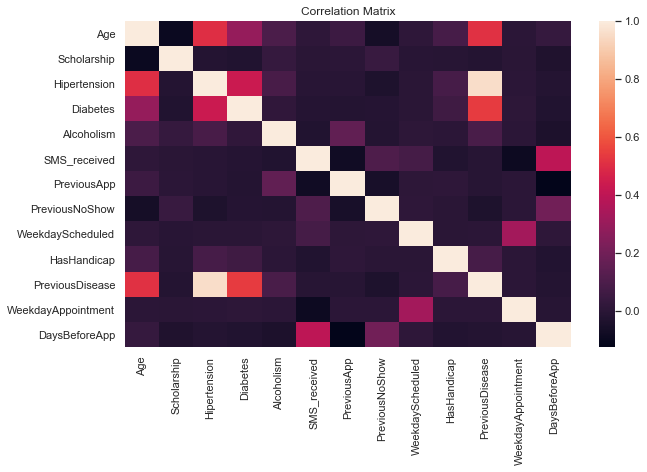

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,PreviousApp,PreviousNoShow,WeekdayScheduled,HasHandicap,PreviousDisease,WeekdayAppointment,DaysBeforeApp
Age,1.000000,-0.092419,0.504519,0.292288,0.095851,0.012667,0.051139,-0.062716,0.011383,0.083916,0.514489,0.002418,0.034943
Scholarship,-0.092419,1.000000,-0.019621,-0.024825,0.035064,0.001131,0.005670,0.043050,-0.005071,-0.009056,-0.019453,-0.000656,-0.030585
Hipertension,0.504519,-0.019621,1.000000,0.433091,0.087985,-0.006129,-0.006750,-0.034698,0.000584,0.085065,0.960210,0.002879,-0.017070
Diabetes,0.292288,-0.024825,0.433091,1.000000,0.018547,-0.014509,-0.016323,-0.012893,-0.000442,0.059293,0.538975,0.006319,-0.027110
Alcoholism,0.095851,0.035064,0.087985,0.018547,1.000000,-0.026098,0.156563,-0.016669,0.006745,0.003731,0.090004,0.002598,-0.038514
SMS_received,0.012667,0.001131,-0.006129,-0.014509,-0.026098,1.000000,-0.077121,0.104344,0.078954,-0.025255,-0.008035,-0.090093,0.398143
PreviousApp,0.051139,0.005670,-0.006750,-0.016323,0.156563,-0.077121,1.000000,-0.053735,0.009562,0.011253,-0.009794,0.003941,-0.125677
PreviousNoShow,-0.062716,0.043050,-0.034698,-0.012893,-0.016669,0.104344,-0.053735,1.000000,0.011911,0.000509,-0.034802,0.003191,0.203616
WeekdayScheduled,0.011383,-0.005071,0.000584,-0.000442,0.006745,0.078954,0.009562,0.011911,1.000000,0.001294,0.002026,0.329084,0.014643
HasHandicap,0.083916,-0.009056,0.085065,0.059293,0.003731,-0.025255,0.011253,0.000509,0.001294,1.000000,0.084859,0.004669,-0.020912


In [111]:
features0 = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'SMS_received','PreviousApp', 'PreviousNoShow', 'WeekdayScheduled', 'HasHandicap',
       'PreviousDisease', 'WeekdayAppointment', 'DaysBeforeApp',
       'DaysBeforeCat']
corr = df_done[features0].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(10, 6)
plt.show()

corr

From the matrix, we can see that Hipertension is highly correlated with PreviousDisease, Age and Diabetes. Also, Age is highly correlated with PreviousDisease. For this reason, we will eliminate PreviousDisease from the analysis but shall keep the others (correlation is high but not extreme). 

Previously, NaN values didn't matter, as XGBoost learned from the data which path was the best. As now observations with missing values can not be used, we will change the variable PreviousNoShow as MissedAppointments : number of previous appointments with no-show. 

Also, we will scale the data so all values are between 1 and 0. 

In [112]:
df_done.loc[:, 'MissedAppointments'] = df_done.sort_values(['ScheduledDay']).groupby(['PatientId'])['NoShow'].cumsum()

In [113]:
features2 = ['Age','Scholarship','Hipertension','Diabetes', 'Alcoholism', 'SMS_received',
             'PreviousApp','MissedAppointments','HasHandicap', 'ScheduledMonday',
             'ScheduledTuesday', 'ScheduledWednesday', 'ScheduledThursday', 'ScheduledFriday',
             'AppointmentMonday', 'AppointmentTuesday', 'AppointmentWednesday',
             'AppointmentThursday', 'AppointmentFriday','IsFemale', 'Ant0Days', 'Ant12Days',
             'Ant37Days', 'Ant831Days', 'Ant32Days']

In [114]:
scaler = StandardScaler().fit(df_done[features2])
df_rescaled = scaler.transform(df_done[features2])

X_train, X_test, y_train, y_test = train_test_split(df_done[features2], df_done[label], test_size=0.3, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

In [115]:
logit = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
modelfit(logit, train, test, features2, label, eval_metric = False)

 Model Report
Accuracy Train: 0.934
Recall Train: 0.9584
Accuracy Test: 0.9345
Recall Test: 0.9588
AUC Score (Train): 0.967967


Accuracy is way better than XGBoost ! Compared to naive model, we got an improvement of almost 14% for test data on accuracy. 

We will train a **Decision Tree**, just to check how does this model compare to the two we already have. 

In [117]:
tree = DecisionTreeClassifier(max_depth=12, random_state=0)
modelfit(tree, train, test,features2, label, eval_metric=False)

 Model Report
Accuracy Train: 0.9548
Recall Train: 0.885
Accuracy Test: 0.944
Recall Test: 0.8559
AUC Score (Train): 0.992040


The decision tree performs even better for accuracy! If we set class_weight as 'balanced', recall is higher but accuracy lowers its value. As explained before, medical hospitals contacted prefered accuracy over recall so we choose the tree without balance. Keep in mind that having recall over 0.85 is very high (85% of no-shows are being captured by the model) ! 

Finally, we will train a **Random Forest**: as one decision tree performed better, maybe several decision trees perform best. 

In [118]:
rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
modelfit(rf, train, test,features2, label, eval_metric=False)

 Model Report
Accuracy Train: 0.992
Recall Train: 0.9808
Accuracy Test: 0.9386
Recall Test: 0.8274
AUC Score (Train): 0.999572


The best so far !! We will use this model to study variable importance and predictive power. 

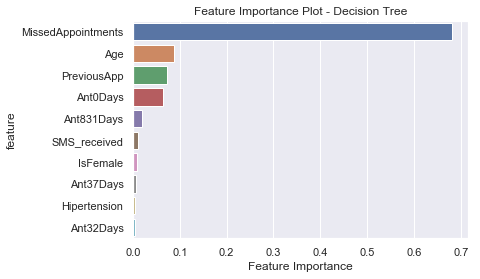

In [119]:
feature_importance = pd.DataFrame({'feature' : features2,
                                   'importances' : rf.feature_importances_})
ordered = feature_importance.sort_values(['importances'], ascending = False)
best = ordered[:10]
sns.barplot(x = 'importances', y = 'feature', data = best)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot - Decision Tree')
plt.show()

We can see that the most important feature is "MissedAppointments", "Age" and "PreviousApp". Two of these three variables make reference to the patient's past behavior, which supports the hypothesis of patients repeating behaviors over time. As we have little history this is not enough to say that patients will always behave the same way but for this period of time this is true. 

For better understanding, we will use SHAP Values. DanB made a marvelous job explaining advanced uses of SHAP Values (see [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values))  and for better understanding you can check this [medium post](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) . 

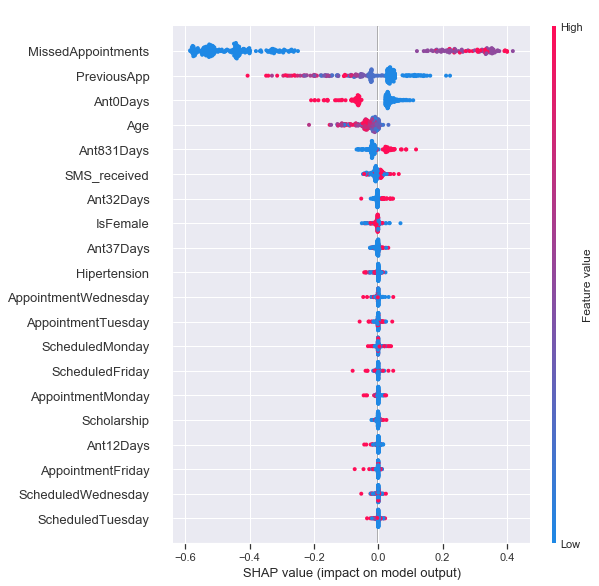

In [120]:
sample = X_test.sample(300)
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(sample[features2])
shap.summary_plot(shap_values[1], sample[features2])

From SHAP Values, we can see that the most important variable is "MissedAppointments" (as mentioned before). In fact, this variable is able to divide the data, impact negatively on the model output for low values of MissedApointments and impact positively for higher values of missed appointments (which makes sense). 

Another variable to watch is "Ant0days". As a reminder, this variable takes the value 1 when the appointment was scheduled with less than a day of anticipation and 0 for any other case (which means that low values of the variable correspond to appointments scheduled with at least one day of anticipation, while high values are for appointments with less than a day of anticipation). In the plot above, we can see there's a clear separation for Ant0days: appointments with value 1 lower the chanses of noshow, while appointments with value 0 receive a positive impact (elevates chances of no-show, also makes sense). 

Now we shall study how the model clasificates in general: 

True Positive Rate (recall): 0.935
Accuracy: 0.976


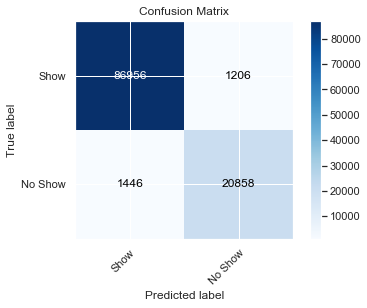

In [121]:
df_done['preds'] = rf.predict(df_done[features2])
cm = metrics.confusion_matrix(df_done['NoShow'], (df_done['preds'] > 0.5)*1)
normalize = False 

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Show', 'No Show'], yticklabels=['Show', 'No Show'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax

print('True Positive Rate (recall): {:1.3f}'.format(metrics.recall_score(df_done['NoShow'], (df_done['preds'] > 0.5)*1)))
print('Accuracy: {:1.3f}'.format(metrics.accuracy_score(df_done['NoShow'], (df_done['preds'] > 0.5)*1)))

From the above, we can see how the random forest classifies correctly or incorrectly each appointment. The model is able to correctly predict more than 93% of No-Shows, which is very high. At the same time, more than 97% of cases are correctly labeled so the hospital should expect less than 3% of error (very very low). 

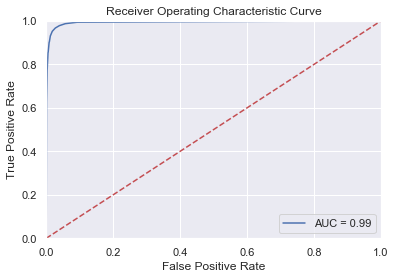

In [122]:
# ROC Curve 
probs = rf.predict_proba(df_done[features2])[:,1]

fpr, tpr, threshold = metrics.roc_curve(df_done['NoShow'], probs)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC Curve is almost perfect ! We have very early return (high true positive rate with low false positive rate, the ideal) which indicates that the model is very good. 

Sometimes accuracy this high (over 90%) makes one wonder if we are overfitting data and that if we change the sample, the model will lower it's performance. However we must keep in mind that, because we have a very unbalanced data set, the naive model already has accuracy score near 80%, so this should be our point of start. In most "academic" excercises, data is perfectly balanced (50-50) so achieving accuracy above 90% is considered at least suspicious.But for unbalanced data, this doesn't apply (actually, no model should give accuracy below the naive model). 